Slice Sampling

Slice sampling is a Markov Chain Monte Carlo (MCMC) method that allows you to draw samples from a target distribution without needing to compute its normalization constant. It works by introducing auxiliary variables and sampling them iteratively to explore the target distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the target distribution: a Gaussian
def target_distribution(x):
    return np.exp(-0.5 * x**2)  # Unnormalized Gaussian

In [3]:
# Function to perform slice sampling
def slice_sample(num_samples, w=1.0):
    samples = []
    # Start with an initial value
    x_current = np.random.randn()  # Random starting point

    for _ in range(num_samples):
        # Step 1: Sample height
        y = np.random.uniform(0, target_distribution(x_current))

        # Step 2: Sample a slice
        # Define the slice boundaries
        x_left = x_current - w * np.random.rand()
        x_right = x_left + w

        # Step 3: Expand the slice until we find a valid sample
        while target_distribution(x_left) > y:
            x_left -= w

        while target_distribution(x_right) > y:
            x_right += w

        # Step 4: Sample from the slice
        x_new = np.random.uniform(x_left, x_right)

        # Step 5: Accept or reject the new sample
        if np.random.uniform(0, 1) < target_distribution(x_new) / target_distribution(x_current):
            x_current = x_new  # Accept the new sample

        samples.append(x_current)

    return np.array(samples)

In [4]:
# Parameters
num_samples = 1000
samples = slice_sample(num_samples)

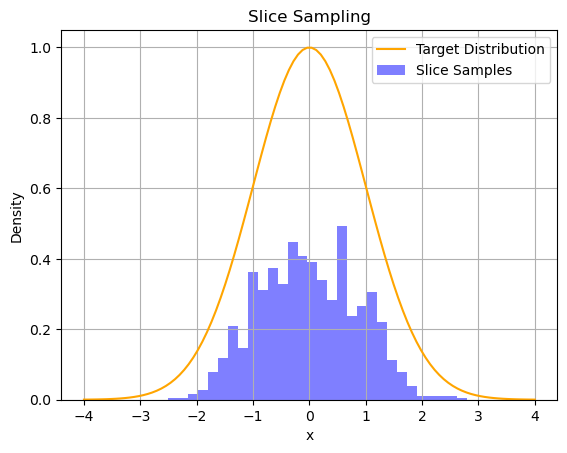

In [5]:
# Plot the results
x = np.linspace(-4, 4, 100)
plt.plot(x, target_distribution(x), label='Target Distribution', color='orange')
plt.hist(samples, bins=30, density=True, alpha=0.5, label='Slice Samples', color='blue')
plt.title('Slice Sampling')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

NUTs sample example from GPT

ChatGPT example 1

In [6]:
import autograd.numpy as anp
from autograd import grad

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def log_prob(theta):
    # Target distribution: 2D standard normal distribution
    return -0.5 * np.sum(theta**2)

def grad_log_prob(theta):
    # Gradient of the log-probability (for a 2D standard normal)
    return -theta

def leapfrog(theta, r, epsilon):
    # Leapfrog integrator step
    r -= 0.5 * epsilon * grad_log_prob(theta)
    theta += epsilon * r
    r -= 0.5 * epsilon * grad_log_prob(theta)
    return theta, r

def build_tree(theta, r, u, v, j, epsilon):
    if j == 0:  # Base case: take one leapfrog step
        theta_new, r_new = leapfrog(theta, r, v * epsilon)
        joint = log_prob(theta_new) - 0.5 * np.sum(r_new ** 2)
        n = int(u <= np.exp(joint))
        s = int(u < np.exp(100) * np.exp(joint))  # Check if the state is valid
        return theta_new, r_new, theta_new, r_new, theta_new, n, s
    else:  # Recursive case: build the left and right subtrees
        theta_minus, r_minus, theta_plus, r_plus, theta_new, n, s = build_tree(theta, r, u, v, j-1, epsilon)
        if s == 1:
            if v == -1:
                theta_minus, r_minus, _, _, theta_new_left, n_left, s_left = build_tree(theta_minus, r_minus, u, v, j-1, epsilon)
            else:
                _, _, theta_plus, r_plus, theta_new_right, n_right, s_right = build_tree(theta_plus, r_plus, u, v, j-1, epsilon)

            # Combine the left and right subtree results
            if v == -1 and np.random.uniform() < n_left / (n + n_left):
                theta_new = theta_new_left
            elif v == 1 and np.random.uniform() < n_right / (n + n_right):
                theta_new = theta_new_right

            n += n_left if v == -1 else n_right
            s *= s_left if v == -1 else s_right

        return theta_minus, r_minus, theta_plus, r_plus, theta_new, n, s

def nuts(theta0, num_samples, epsilon):
    samples = []
    theta = theta0
    for _ in range(num_samples):
        r0 = np.random.normal(0, 1, size=theta.shape)  # Sample initial momentum
        u = np.random.uniform(0, np.exp(log_prob(theta) - 0.5 * np.sum(r0 ** 2)))  # Slice variable
        theta_minus, theta_plus = theta, theta
        r_minus, r_plus = r0, r0
        j, n, s = 0, 1, 1
        theta_new = theta

        while s == 1:  # While no U-turn is detected
            v = np.random.choice([-1, 1])  # Choose forward or backward direction randomly
            if v == -1:
                theta_minus, r_minus, _, _, theta_new_left, n_left, s_left = build_tree(theta_minus, r_minus, u, v, j, epsilon)
            else:
                _, _, theta_plus, r_plus, theta_new_right, n_right, s_right = build_tree(theta_plus, r_plus, u, v, j, epsilon)

            if np.random.uniform() < n_left / (n + n_left):
                theta_new = theta_new_left if v == -1 else theta_new_right

            n += n_left if v == -1 else n_right
            s *= s_left if v == -1 else s_right
            j += 1

        samples.append(theta_new)

    return np.array(samples)

# Parameters
num_samples = 1000
epsilon = 0.1

# Initial guess for theta (2D Gaussian)
theta0 = np.random.randn(2)

# Run NUTS
samples = nuts(theta0, num_samples, epsilon)

# Plot the samples
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.title('NUTS Samples')
plt.show()


UnboundLocalError: cannot access local variable 'n_left' where it is not associated with a value

ChatGPT example 2

In [ ]:
import numpy as np

# Target log-probability (e.g., standard normal distribution)
def target_log_prob(x):
    return -0.5 * np.sum(x**2)

# Gradient of the log-probability
def grad_log_prob(x):
    return -x

# Leapfrog integrator
def leapfrog(x, p, step_size):
    p_new = p - 0.5 * step_size * grad_log_prob(x)  # Half step for momentum
    x_new = x + step_size * p_new                   # Full step for position
    p_new = p_new - 0.5 * step_size * grad_log_prob(x_new)  # Half step for momentum
    return x_new, p_new

# Hamiltonian
def hamiltonian(x, p):
    return -target_log_prob(x) + 0.5 * np.sum(p**2)

# Build the NUTS sampler
class NUTS:
    def __init__(self, step_size=0.1, max_depth=10):
        self.step_size = step_size
        self.max_depth = max_depth

    def build_tree(self, x, p, u, v, j, step_size):
        if j == 0:
            # Base case: take one leapfrog step in direction v
            x_new, p_new = leapfrog(x, p, v * step_size)
            h_new = hamiltonian(x_new, p_new)
            valid = u < np.exp(-h_new)
            return x_new, p_new, x_new, p_new, valid, min(1.0, np.exp(-h_new))
        else:
            # Recursively build the left and right subtrees
            x_neg, p_neg, x_pos, p_pos, valid, prob = self.build_tree(x, p, u, v, j - 1, step_size)
            if valid:
                if np.random.rand() < 0.5:
                    x_new, p_new = x_neg, p_neg
                else:
                    x_new, p_new = x_pos, p_pos
                if v == -1:
                    x_neg, p_neg, _, _, valid2, prob2 = self.build_tree(x_neg, p_neg, u, v, j - 1, step_size)
                else:
                    _, _, x_pos, p_pos, valid2, prob2 = self.build_tree(x_pos, p_pos, u, v, j - 1, step_size)
                valid &= valid2
                prob += prob2
            else:
                x_new, p_new = x_neg, p_neg
            return x_neg, p_neg, x_pos, p_pos, valid, prob

    def sample(self, x_init, num_samples):
        samples = []
        x = np.copy(x_init)

        for _ in range(num_samples):
            p = np.random.randn(*x.shape)  # Sample momentum
            h = hamiltonian(x, p)
            u = np.random.rand() * np.exp(-h)

            # Initialize variables for tree expansion
            x_neg = np.copy(x)
            x_pos = np.copy(x)
            p_neg = np.copy(p)
            p_pos = np.copy(p)

            j = 0  # Tree depth
            valid = True
            prob = 1.0
            x_new = np.copy(x)

            while valid and j < self.max_depth:
                # Sample direction v = -1 or 1
                v = np.random.choice([-1, 1])
                if v == -1:
                    x_neg, p_neg, _, _, valid, prob_new = self.build_tree(x_neg, p_neg, u, v, j, self.step_size)
                else:
                    _, _, x_pos, p_pos, valid, prob_new = self.build_tree(x_pos, p_pos, u, v, j, self.step_size)
                prob += prob_new
                if valid:
                    if np.random.rand() < prob_new / prob:
                        x_new = np.copy(x_pos if v == 1 else x_neg)
                j += 1

            samples.append(np.copy(x_new))
            x = x_new  # Update the current position

        return np.array(samples)

# Parameters
step_size = 0.1
num_samples = 20000
x_init = np.array([0.0])

# Run NUTS
nuts = NUTS(step_size=step_size)
samples = nuts.sample(x_init, num_samples)

# Print the first few samples
print(samples[:10])


In [ ]:
samples.shape

In [ ]:
# Plot results
plt.hist(samples, bins=50, density=True, alpha=0.7, label='Nuts samples')
x = np.linspace(-4, 4, 100)
# plt.plot(x, normal_pdf(x, mu, sigma), label='Target Normal PDF', color='red')
plt.title('Hamiltonian Monte Carlo Sampling')
plt.legend()
plt.show()

Another NUTs - https://github.com/snormoyle/nuts_sampler/blob/master/Final_WriteUp.ipynb

In [ ]:
def Leapfrog_slow(theta, r, eps, L):
    """
    SUMMARY: 
    From Algorithm 1 in NUTS, Leapfrog step in Hamiltonian Monte Carlo/NUTS.
    Helper function for Algorithm 6. 
    
    INPUTS:
    theta = vector of parameters, len(theta) = number of parameters in the model, 
    np.array or list
    
    r = input from other function, momentum in Hamiltonian dynamics
    
    eps = step size
    
    L = function from model that returns the log likelihood and the gradient like:
    logp, grad = L(theta)
       
    OUTPUTS:
    theta_tilde = update theta vector
    
    r_tilde = updated r momenta vector
    """
    
    logp, grad = L(theta)
    r_tilde = r + (eps/2) * grad
    theta_tilde = theta + eps * r_tilde
    logp_tilde, grad_tilde = L(theta_tilde)
    r_tilde = r_tilde + (eps/2) * grad_tilde
    return theta_tilde, r_tilde

In [ ]:
def FindReasonableEpsilon_slow(theta, L):
    """
    SUMMARY:
    From Algorithm 4 in NUTS.
    Heuristic for choosing an initial value of epsilon.
    Helper function for Algorithm 6.
    
    INPUTS:
    theta = vector of parameters, len(theta) = number of parameters in the model, 
    np.array or list
    
    L = function from model that returns the log likelihood and the gradient like:
    logp, grad = L(theta)
    
    
    OUTPUTS:
    eps = value for initial value of epsilon, step size
    
    """
    #initialize
    parems = len(theta)
    eps = 1
    r = np.random.multivariate_normal(np.zeros(parems), np.identity(parems), 1)
    r = r.ravel()
    theta_prime, r_prime = Leapfrog_slow(theta, r, eps, L)
    
    logp, grad = L(theta)
    logp_prime, grad_prime = L(theta_prime)
    
    prob = np.exp(logp_prime - logp - 0.5 * (np.dot(r_prime, r_prime) - np.dot(r, r)))
    a = 2 * int(prob > 0.5) - 1

    while prob**a > 2**(-a):
        eps = 2**a * eps
        theta_prime, r_prime = Leapfrog_slow(theta, r, eps, L);
        logp_prime, grad_prime = L(theta_prime)
        prob = np.exp(logp_prime - logp - 0.5 * (np.dot(r_prime, r_prime) - np.dot(r,r)))
    return eps

In [ ]:
def BuildTree_slow(theta, r, u, v, j, eps, r_theta0, L):
    """
    SUMMARY:
    builds tree in NUTS sampler, helper function for Algorithm 6
    
    INPUTS:
    
    theta = vector of parameters, len(theta) = number of parameters in the model, 
    np.array or list
    
    r = input from other function, momentum in Hamiltonian dynamics
    
    v = direction in creating tree, value from -1 to 1
    
    j = height of tree, starts at 0
    
    eps = step size
    
    r_theta0 = joint probability of theta0 and r
    
    L = function from model that returns the log likelihood and the gradient like:
    logp, grad = L(theta)
    
    
    OUTPUTS:
    theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha_prime, n_alpha_prime
    
    """
    if j == 0: 
        # base case, take one leapfrog step in the direction v
        theta_prime, r_prime = Leapfrog_slow(theta, r, v*eps, L)
        logp_prime, grad_prime = L(theta_prime)
        
        r_theta = logp_prime - 0.5 * np.dot(r_prime, r_prime)      

        n_prime = int(u <= np.exp(r_theta))   
        s_prime = int(r_theta > np.log(u) - 1000)
        alpha_prime = min(1, np.exp(r_theta - r_theta0))
                                                   
        return theta_prime, r_prime, theta_prime, r_prime, theta_prime, n_prime, s_prime, alpha_prime, 1
    else:
        # recursion, build left and right subtrees
        theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha_prime, n_alpha_prime = BuildTree_slow(theta, r, u, v, j-1, eps, r_theta0, L)
        
        if s_prime == 1:
            if v == -1:
                theta_minus, r_minus, _,_, theta_doub_prime, n_doub_prime, s_doub_prime, alpha_doub_prime, n_alpha_doub_prime = BuildTree_slow(theta_minus, r_minus, u, v, j-1, eps, r_theta0, L)
            else:
                _, _, theta_plus, r_plus, theta_doub_prime, n_doub_prime, s_doub_prime, alpha_doub_prime, n_alpha_doub_prime = BuildTree_slow(theta_plus, r_plus, u, v, j-1, eps, r_theta0, L)

            # Use Metropolis-Hastings
            prob = n_doub_prime / max(n_prime + n_doub_prime,1)
            if (np.random.uniform(0, 1, 1) < prob):
                theta_prime = theta_doub_prime
            
            ind_1 = int(np.dot(theta_plus-theta_minus, r_minus) >= 0)
            ind_2 = int(np.dot(theta_plus-theta_minus, r_plus) >= 0)
            s_prime = s_prime * s_doub_prime * ind_1 * ind_2
            n_prime = n_prime + n_doub_prime
            alpha_prime = alpha_prime + alpha_doub_prime
            n_alpha_prime = n_alpha_prime + n_alpha_doub_prime
        
        return theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha_prime, n_alpha_prime

In [ ]:
def nuts6_dual_averaging_slow(theta0, M, M_adapt, L, delta = 0.6):
    """
    SUMMARY: 
    Not optimized version. 
    Implemented from Algorithm 6: NUTS with Dual Averaging.
    Needs helper functions BuildTree_slow, FindReasonableEpsilon_slow, and Leapfrog_slow.
    

    INPUTS:
    
    theta0 = initial values for values of parameters in model. len(theta0) = number of parameters
    
    M = number of samples desired
    
    M_adapt = the number of steps for the burn-in,
    also how long to run the dual averaging algorithm to find the appropriate epsilon
    
    L = function from model that returns the log likelihood and the gradient like:
    logp, grad = L(theta)
    
    delta = target HMC acceptance probability.
    default value of 0.6
    is a value between 0 and 1
    
    
    OUTPUTS:
    
    samples = np.array matrix of samples of theta from algorithm
    dimensions of matrix are M x len(theta0)
    
    burned_in = same as samples matrix with burn_in samples removed
    dimensions of matrix are are M-M_adapt x len(theta0)
    
    """
    # initialize samples matrix
    # put initial theta0 in first row of matrix
    parems = len(theta0)
    samples = np.empty((M+1, parems))
    samples[0, :] = theta0
    eps = FindReasonableEpsilon_slow(theta0, L)
    mu = np.log(10*eps)
    eps_bar = 1
    H_bar = 0
    gamma = 0.05
    t0 = 10
    k = 0.75
    
    for m in range(1, M+1):
        # resample
        norm_samp = np.random.multivariate_normal(np.zeros(parems), np.identity(parems), 1)
        r0 = norm_samp.ravel()
        logp, grad = L(samples[m-1,:])

        r_theta = logp - 0.5 * np.dot(r0,r0)
        # resample u ~ uniform([0, exp(inside)])
        u = np.random.uniform(0, np.exp(r_theta), 1)

        # initialize minus's and plus's
        theta_minus = samples[m-1, :]
        theta_plus = samples[m-1, :]
        r_minus = r0
        r_plus = r0
        j = 0 
        
        samples[m, :] = samples[m-1, :]
        n = 1
        s = 1
        
        while s == 1:
            v_j = np.random.uniform(-1,1,1)
            if v_j == -1:
                theta_minus, r_minus, _, _, theta_prime, n_prime, s_prime, alpha, n_alpha = BuildTree_slow(theta_minus, r_minus, u, v_j, j, eps, r_theta, L)
            else:
                _, _, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha, n_alpha = BuildTree_slow(theta_plus, r_plus, u, v_j, j, eps, r_theta, L)
            
            if s_prime == 1:
                # Use Metropolis-Hastings
                prob = min(1, n_prime/n)
                if (np.random.uniform(0,1,1) < prob):
                    samples[m, :] = theta_prime
                    
            n = n + n_prime

            boolean_1 = int(np.dot(theta_plus-theta_minus, r_minus) >= 0)
            boolean_2 = int(np.dot(theta_plus-theta_minus, r_plus) >= 0)
            s = s_prime * boolean_1 * boolean_2
            j = j + 1
            
        if m <= M_adapt:
            H_bar = (1 - 1/(m+t0))*H_bar + (1/(m+t0)) * (delta - alpha/n_alpha)
            eps = np.exp(mu - np.sqrt(m)/gamma * H_bar)
            eps_bar = np.exp(m**(-k) * np.log(eps) + (1-m**(-k))*np.log(eps_bar))
        else:
            eps = eps_bar
            
    burned_in = samples[M_adapt+1:M+1, :]
    
    return samples, burned_in

In [ ]:
# Set seed
np.random.seed(5)

In [ ]:
# generate random poisson data
X_pois = np.random.poisson(5, 100)
def L_pois(theta):
    grad = sum(X_pois) / theta - 100
    logp = sum(X_pois)*np.log(theta) - theta*100
    return logp, grad

In [ ]:
%%time
# run slow algorithm on poisson data
samples_pois, burned_in_pois_slow = nuts6_dual_averaging_slow(np.array([2]), 5000, 2000, L_pois)
print("The run time from the slow algorithm on the poisson data is:")

In [ ]:
samples_pois

In [ ]:
np.mean(samples_pois)

In [ ]:
plt.hist(samples_pois,density=True, bins = 30)
plt.show()

In [ ]:
print("The mean of the data is:")
np.mean(X_pois)

In [ ]:
print("The mean of generated samples is:")
np.mean(samples_pois)